# Explore here

The dataset is composed of dog and cat photos provided as a subset of photos from a much larger collection of 3 million manually annotated photos. This data was obtained through a collaboration between Petfinder.com and Microsoft.

Step 1: Loading the dataset
The dataset is located in Kaggle and you will need to access it to download it. 

Step 2: Visualize the input information
The first step when faced with a picture classification problem is to get as much information as possible through the pictures. Therefore, load and print the first nine pictures of dogs in a single figure. Repeat the same for cats. You can see that the pictures are in color and have different shapes and sizes. Preprocess the data to ensure they all have a fixed size of 200x200 pixels.

If you have more than 12 gigabytes of RAM, use the Keras image processing API to load the 25,000 photos into the training dataset and reshape them to 200×200 pixel square photos. The label must also be determined for each photo based on the file names. A tuple of photos and labels should be saved.
If you have no more than 12 gigabytes of RAM, load the images progressively using the Keras ImageDataGenerator class and the flow_from_directory() function. This will be slower to run but it will run on less capable hardware. This function prefers the data to be split into separate train and test directories, and under each directory to have a subdirectory for each class.
Once you have all the images processed, create an ImageDataGenerator object for training and test data. Then pass the folder that has training data to the trdata object and, similarly, pass the folder that has test data to the tsdata object. In this way, the images will be automatically labeled, and everything will be ready to enter the network.

Step 3: Build an ANN
Any classifier that fits this problem will have to be robust because some images show the cat or dog in a corner, or perhaps 2 cats or dogs in the same picture. If you have been able to research some of the winner implementations of other competitions also related to images, you will see that VGG16 is a CNN architecture used to win the Kaggle ILSVR (Imagenet) competition in 2014. It is considered one of the best performing vision model architectures to date.

Step 4: Optimize the above model
Import the ModelCheckpoint and EarlyStopping method from Keras. Create an object of both and pass them as callback functions to fit_generator. Load the best model and use the test set to make predictions.

Step 5: Save the model
Store the model in the corresponding folder.

In [5]:
import os
import shutil
import zipfile
import random
from PIL import Image
import numpy as np
from tensorflow.keras.optimizers import AdamW
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Input

2025-03-26 14:19:16.675107: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 14:19:16.924310: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 14:19:17.066956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742998757.284103     686 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742998757.382266     686 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742998758.061438     686 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Connect Kaggle API

In [6]:
load_keys = False

if load_keys:
    # load the .env file variables
    load_dotenv()

    os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
    os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")

    import kaggle
    kaggle.api.authenticate()

## Load and Unzip Data

In [7]:

load_docs = False

if load_docs:
    kaggle.api.competition_download_files('dogs-vs-cats', path='/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw')

    raw_data_path = "/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw/"

    train_zip = os.path.join(raw_data_path, "train.zip")
    test_zip = os.path.join(raw_data_path, "test1.zip")

    train_extract_path = os.path.join(raw_data_path, "train")
    test_extract_path = os.path.join(raw_data_path, "test")

    # Function to extract a zip file
    def extract_zip(zip_file, extract_to):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

    # Extract train and test zip files
    extract_zip(train_zip, train_extract_path)
    extract_zip(test_zip, test_extract_path)

    os.remove(train_zip)
    os.remove(test_zip)

## Print out cat and dog photos

In [8]:
def get_images(type, path):
    # Define the folder path
    folder_path = path

    # Get a list of all images (assuming they have the 'type' in their filename)
    images = [img for img in os.listdir(folder_path) if type in img.lower()]

    # Select 9 random images
    selected_images = random.sample(images, 9)

    # Create a 3x3 plot
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    # Loop through the images and plot them
    for ax, img_name in zip(axes.flatten(), selected_images):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")  # Hide axes

    plt.show()

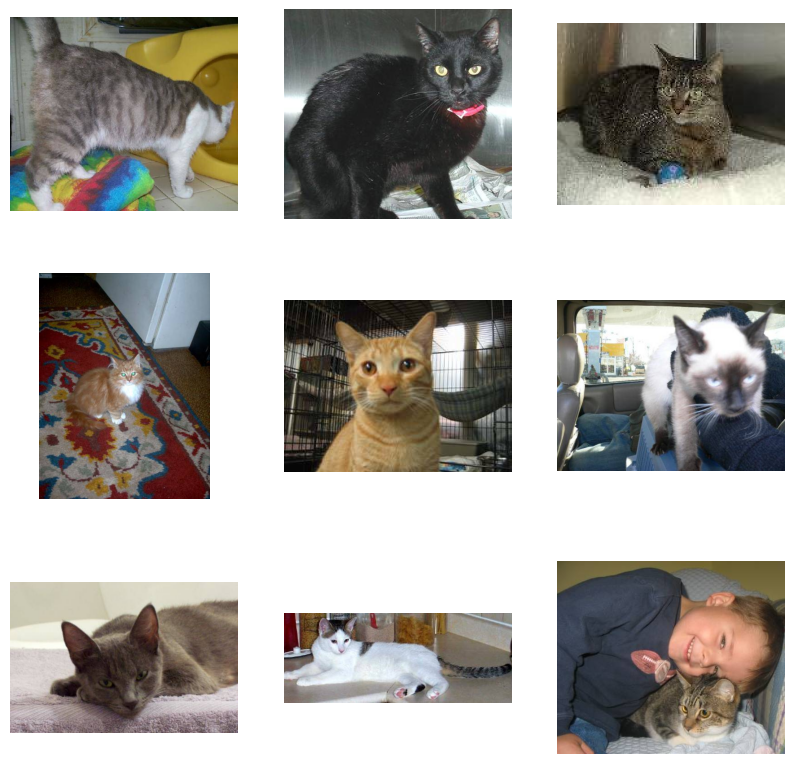

In [9]:
cat_path = '/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw/train/train/cats'
get_images('cat', cat_path)

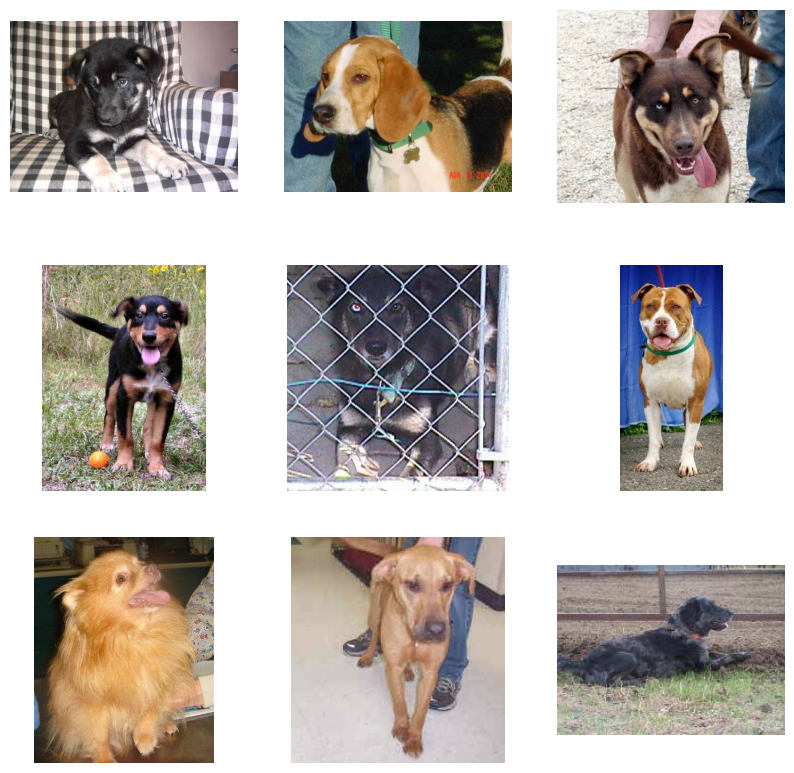

In [10]:
dog_path = '/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw/train/train/dogs'
get_images('dog', dog_path)

## Count The Number Photos

In [11]:
test_dir = '/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw/test/test1'

# Function to count images
def count_images(directory, name):
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return 0
    
    # Filter only image files (common extensions)
    image_extensions = (".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".webp")
    image_files = [file for file in os.listdir(directory) if file.lower().endswith(image_extensions)]
    print(f"{name} Folder total images: {len(image_files)}")
    
# Count and print
count_images(dog_path, 'Dog Training')
count_images(cat_path, 'Cat Training')
count_images(test_dir, 'Testing')

Dog Training Folder total images: 11500
Cat Training Folder total images: 11500
Testing Folder total images: 12500


In [12]:
create_subfolders = False

if create_subfolders:
    base_dir = '/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw/train/train'
    cat_dir = os.path.join(base_dir, "cats")
    dog_dir = os.path.join(base_dir, "dogs")

    os.makedirs(cat_dir, exist_ok=True)
    os.makedirs(dog_dir, exist_ok=True)

    # Get only files (avoid including directories)
    file_list = [f for f in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, f))]

    # Separate cat and dog images
    cat_list = [img for img in file_list if 'cat' in img.lower()]
    dog_list = [img for img in file_list if 'dog' in img.lower()]

    # Move images
    for img in cat_list:
        shutil.move(os.path.join(base_dir, img), os.path.join(cat_dir, img))

    for img in dog_list:
        shutil.move(os.path.join(base_dir, img), os.path.join(dog_dir, img))

## Create and Check Validation Folder

In [13]:
create_val_folder = False

if create_val_folder:
    base_dir = '/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw/train/train'
    dog_train_dir = os.path.join(dog_path, "dogs")
    cat_train_dir = os.path.join(cat_path, "cats")

    validation_dir = os.path.join(base_dir, 'validation')
    os.makedirs(validation_dir)

    cat_valid_dir = os.path.join(validation_dir, "cats")
    dog_valid_dir = os.path.join(validation_dir, "dogs")

    os.makedirs(cat_valid_dir, exist_ok=True)
    os.makedirs(dog_valid_dir, exist_ok=True)

    cat_list = [img for img in os.listdir(cat_train_dir) if 'cat' in img.lower()]
    dog_list = [img for img in os.listdir(dog_train_dir) if 'dog' in img.lower()]

    cat_images = random.sample(cat_list, 1000)
    dog_images = random.sample(dog_list, 1000)

    for img in cat_images:
        shutil.move(os.path.join(cat_train_dir, img), os.path.join(cat_valid_dir, img))

    for img in dog_images:
        shutil.move(os.path.join(dog_train_dir, img), os.path.join(dog_valid_dir, img))

In [14]:
validation_cats = '/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw/validation/cats'
validation_dogs = '/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw/validation/dogs'
count_images(validation_cats, 'Validation Cat')
count_images(validation_dogs, 'Validation Dog')

Validation Cat Folder total images: 1000
Validation Dog Folder total images: 1000


## Create the dataloader

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255)
valid_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_dir = "/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw/train/train"
test_dir = "/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw/test"
validation_dir = '/workspaces/Dansah2_DeepLearning_machine-learning-python-template/data/raw/validation'



train_generator = train_data_gen.flow_from_directory(train_dir,
                                                    target_size=(200, 200),
                                                    color_mode='grayscale', 
                                                    batch_size=16)

valid_generator = valid_data_gen.flow_from_directory(validation_dir,
                                                        target_size=(200, 200),
                                                        color_mode='grayscale',
                                                        batch_size=16)

test_generator = test_data_gen.flow_from_directory(test_dir,
                                                    target_size=(200, 200),
                                                    color_mode='grayscale', 
                                                    batch_size=16,
                                                    class_mode=None,
                                                    shuffle=False)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


## Create the Sequential Model

In [16]:
# this is the neural net
model = Sequential()
model.add(Input(shape = (200, 200, 1)))
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))

# These are the dense layerx
model.add(Flatten())
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 2, activation = "softmax"))

2025-03-26 14:19:25.031876: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


2025-03-26 14:19:25.343420: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 301989888 exceeds 10% of free system memory.
2025-03-26 14:19:25.878045: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 301989888 exceeds 10% of free system memory.
2025-03-26 14:19:26.020792: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 301989888 exceeds 10% of free system memory.
2025-03-26 14:19:26.215964: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2025-03-26 14:19:26.302997: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


## Train the Model

In [17]:
optimizer = AdamW()

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])

In [18]:
history = model.fit(train_generator,
                    steps_per_epoch=2,
                    epochs=3,
                    validation_data=valid_generator,
                    validation_steps=2) 

/workspaces/Dansah2_DeepLearning_machine-learning-python-template/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 25s/step - acc: 0.5208 - loss: 0.6889 - val_acc: 0.5312 - val_loss: 0.7628
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 25s/step - acc: 0.4583 - loss: 0.8254 - val_acc: 0.3750 - val_loss: 0.7221
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 24s/step - acc: 0.5000 - loss: 0.6972 - val_acc: 0.5000 - val_loss: 0.6946


In [19]:
def model_stats(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)

    return accuracy, val_accuracy, loss, val_loss, epochs

accuracy, val_accuracy, loss, val_loss, epochs = model_stats(history)

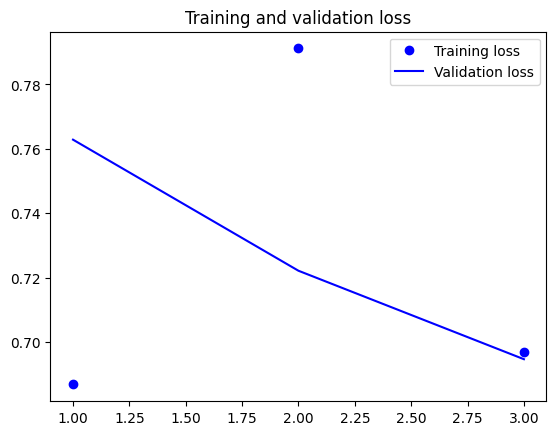

In [20]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_loss(epochs, loss, val_loss)

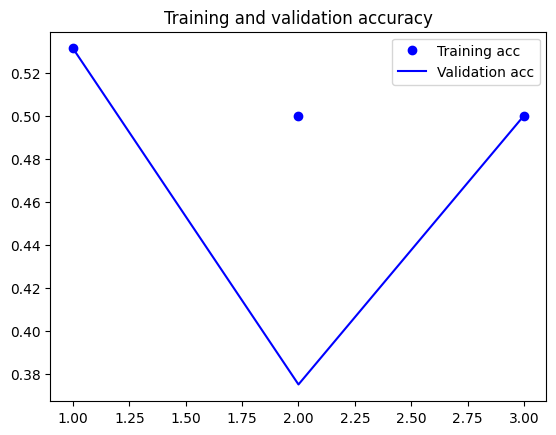

In [21]:
def plot_accuracy(epochs, accuracy, val_accuracy):
    plt.plot(epochs, accuracy, 'bo', label='Training acc')
    plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

plot_accuracy(epochs, accuracy, val_accuracy)

In [22]:
early_stop = EarlyStopping(monitor="val_accuracy", mode='max', patience=3, verbose=1)
checkpoint_callback = ModelCheckpoint("../models/image_model.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, save_weights_only = False, mode = "auto")

In [23]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=3,
                    validation_data=valid_generator,
                    validation_steps=2,
                    callbacks = [checkpoint_callback, early_stop]) 

Epoch 1/3


100/100 ━━━━━━━━━━━━━━━━━━━━ 1542s 15s/step - acc: 0.5068 - loss: 0.6937 - val_acc: 0.6250 - val_loss: 0.6900
Epoch 2/3


/workspaces/Dansah2_DeepLearning_machine-learning-python-template/.venv/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/workspaces/Dansah2_DeepLearning_machine-learning-python-template/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: acc,loss,val_acc,val_loss
  current = self.get_monitor_value(logs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1581s 16s/step - acc: 0.5175 - loss: 0.6930 - val_acc: 0.4062 - val_loss: 0.6939
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 1549s 15s/step - acc: 0.5081 - loss: 0.6932 - val_acc: 0.4062 - val_loss: 0.6978


In [ ]:
test_generator = test_data_gen.flow_from_directory(test_dir,
                                                    target_size=(200, 200),
                                                    color_mode='grayscale', 
                                                    batch_size=16,
                                                    class_mode=None,
                                                    shuffle=False)

In [24]:
accuracy, val_accuracy, loss, val_loss, epochs = model_stats(history)

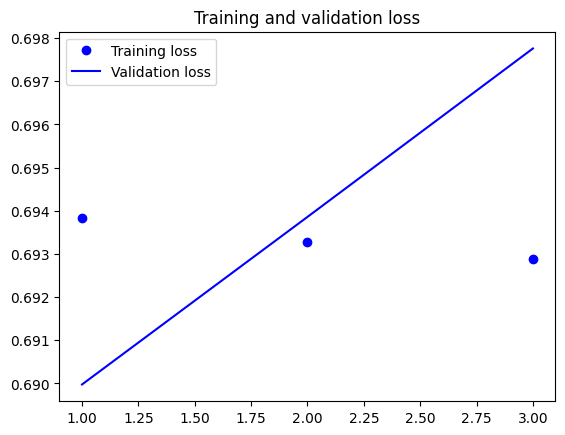

In [25]:
plot_loss(epochs, loss, val_loss)

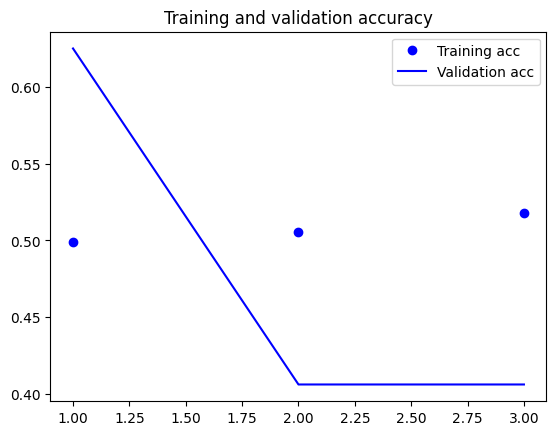

In [26]:
plot_accuracy(epochs, accuracy, val_accuracy)

In [ ]:
predictions = model.predict(test_generator)

# Get the filenames from the generator
filenames = test_generator.filenames

# Get predicted classes
predicted_classes = predictions.argmax(axis=1)

# Get the class mapping from indices to actual labels
class_indices = test_generator.class_indices  # Mapping {'class_name': index}
class_mapping = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Select 9 random images
random_indices = random.sample(range(len(filenames)), 9)
random_files = [filenames[i] for i in random_indices]
random_preds = [predicted_classes[i] for i in random_indices]

/workspaces/Dansah2_DeepLearning_machine-learning-python-template/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/782 ━━━━━━━━━━━━━━━━━━━━ 28:30 4s/step

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img_path = test_dir + "/" + random_files[i]  # Full path to the image
    img = plt.imread(img_path)  # Load image

    # Show image
    ax.imshow(img, cmap="gray")  # Use "gray" colormap if grayscale
    ax.axis("off")

    # Display prediction
    predicted_label = class_mapping[random_preds[i]]
    ax.set_title(f"Pred: {predicted_label}")

plt.tight_layout()
plt.show()